
**Building a simple Convolutional Neural Network (CNN) for image recognition using PyTorch.**

In [1]:
#1. Installing Required Libraries
# Make sure PyTorch is installed. Install it using:

#pip install torch torchvision matplotlib

import torch
print(torch.__version__)


2.5.1+cpu


In [2]:
#2. Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



In [ ]:
#3. Loading and Preprocessing the Data
# Key Functions:

#transforms.ToTensor(): Converts images to PyTorch tensors.

#transforms.Normalize((mean,), (std,)): Normalizes image pixel values.

#DataLoader: Handles batching, shuffling, and parallel data loading.



# Transform to normalize and convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1], we do this for uniformity purposes
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)#must be completely different from test data...
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)#generally we have validation datasets also but lets go on to it later...

# Data loaders for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [ ]:
# 4. Defining the CNN Model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()#flexiblity to the user
        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)#padding is done to avoid giving less attention to the pixels in the edges of the image. output size: [(W-K+2P)/s]+1 
        # Max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)#image will condensed to half of the size of earlier feature maps
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Apply ReLU after convolution
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = torch.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Output layer (no activation; handled by loss function)
        return x





In [ ]:
#check  model has trainable parameters by printing them:
model = CNN().to(device)
print(list(model.parameters()))

[Parameter containing:
tensor([[[[ 0.1154, -0.3168, -0.1498],
          [-0.1384, -0.2459,  0.0334],
          [-0.1107, -0.0815,  0.1763]]],


        [[[-0.2970,  0.1310, -0.0562],
          [-0.0825, -0.1250, -0.2719],
          [-0.1645, -0.1145,  0.0631]]],


        [[[ 0.0459,  0.3112, -0.1478],
          [ 0.0198, -0.3284, -0.2580],
          [-0.0107, -0.1478, -0.3242]]],


        [[[-0.0050, -0.2627,  0.1337],
          [-0.2508, -0.2026, -0.0050],
          [ 0.2191,  0.1001, -0.0049]]],


        [[[-0.3072, -0.1306, -0.2196],
          [-0.2684, -0.2767,  0.0391],
          [ 0.2396,  0.0653,  0.3195]]],


        [[[ 0.2810, -0.0360, -0.0781],
          [ 0.1951, -0.1319,  0.2239],
          [-0.2029, -0.3299,  0.1391]]],


        [[[ 0.0968,  0.0011, -0.1338],
          [-0.0590,  0.2167, -0.1396],
          [ 0.0913,  0.1868,  0.1250]]],


        [[[-0.3135, -0.0523,  0.3244],
          [ 0.0432,  0.1718, -0.0651],
          [-0.2439,  0.1818, -0.0424]]],


        [

** #5. Understanding Each Component

# a. nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

in_channels: Number of input channels (1 for grayscale images).

out_channels: Number of filters (32 in this case).

kernel_size: Size of the filter (3x3 here).

stride: Steps the filter moves (1 here).

padding: Adds padding around the image to maintain dimensions.


# b. nn.MaxPool2d(kernel_size, stride)

Reduces spatial dimensions by taking the maximum value in a region.


# c. nn.Linear(in_features, out_features)

Fully connected layers where each input node is connected to every output node.


# d. torch.relu(x)

Applies the ReLU activation function, setting all negative values to 0.


# e. x.view(x.size(0), -1)

Flattens the output tensor to prepare it for the fully connected layer.


**

In [ ]:
#6. Initializing the Model, Loss Function, and Optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


In [ ]:
# 7. Training the Model

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.2057
Epoch [2/5], Loss: 0.0699
Epoch [3/5], Loss: 0.0467
Epoch [4/5], Loss: 0.0352
Epoch [5/5], Loss: 0.0262


In [ ]:
#8. Evaluating the Model

# Evaluation loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")




Test Accuracy: 98.49%


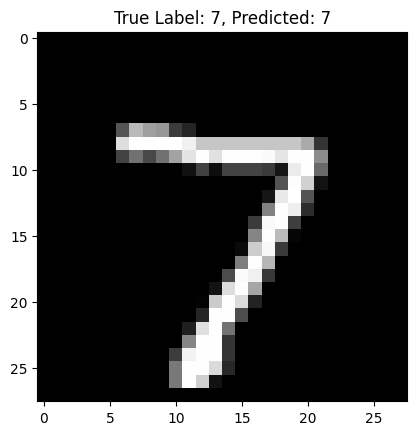

In [ ]:
#9. Visualizing Results

# Display a sample image and prediction
import numpy as np

sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].to(device)
sample_label = sample_label[0].item()

output = model(sample_image.unsqueeze(0))
_, predicted_label = torch.max(output.data, 1)

plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
plt.title(f"True Label: {sample_label}, Predicted: {predicted_label.item()}")
plt.show()



**10. Summary of Workflow

1. Preprocessing: Load and normalize data.


2. Model Architecture: Define a CNN with convolutional, pooling, and fully connected layers.


3. Training: Use the loss function and optimizer to update weights.


4. Evaluation: Measure performance on test data.


5. Visualization: Inspect predictions for sample inputs.



**